# Detectar arritmias cardíacas mediante señales de ECG parcialmente etiquetadas
### INF395 Introducción a las Redes Neuronales and Deep Learning
- Estudiante: Alessandro Bruno Cintolesi Rodríguez
- ROL: 202173541-0

## **1. Librerias**

In [348]:
# === General / Utilidad ===
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Dict

# === PyTorch, PyTorch Lightning, Torchvision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# === Scikit-learn ===
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
	f1_score, accuracy_score, recall_score, confusion_matrix,
	roc_auc_score, classification_report
)

## **2. Variables globales**

In [442]:
# Clases
CLASSES = {
	0: "(N) Latido normal",
	1: "(S) Latido supraventricular",
	2: "(V) Latido ventricular ectópico",
	3: "(F) Latido de fusión",
	4: "(Q) Latido desconocido"
}

# Hiperparámetros revisados
ENCODER = "ResNet1DBackbone" # CNN1DBackbone | InceptionTimeBackbone | ResNet1DBackbone
PROJECTOR = "ProjectionHeadOne" # ProjectionHeadOne | ProjectionHeadTwo
HEAD = "ClassifierHeadOne" # Linear | ClassifierHeadOne | ClassifierHeadTwo
SCHEDULER = "LambdaLR" # LambdaLR | CosineAnnealingLR

LOSS_LP = "CrossEntropy" # CrossEntropy | FocalLoss
GAMMA_LP = 1.5

LOSS_FN = "CrossEntropy" # CrossEntropy | FocalLoss
GAMMA_FN = 1.5

SEED = 42
SIGNALS = 187
EMBEDDING_DIM = 256
PROJ_HID = 256
PROJ_OUT = 128

NUM_WORKERS = 0
BATCH_SSL = 512
BATCH_LP = 256
BATCH_FT = 256

EPOCHS_SSL = 100
EPOCHS_LP = 25
EPOCHS_FT = 25

LR_SSL = 1e-3
LR_LP = 1e-3
LR_FT_HEAD = 5e-4
LR_FT_ENC = 3e-5

WD = 5e-3
TEMP = 0.15

ArrayLike = np.ndarray

## **3. Setup del Dispositivo**

In [443]:
# Seteamos la semilla
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED, workers=True)

# Seteamos el dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
	print("GPU:", torch.cuda.get_device_name(0))

Seed set to 42


Using device: cuda
GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


## **4. Funciones Auxiliares**

In [444]:
def plot_ecg(X, y, aug=False, aug_title=""):
	y_class = CLASSES.get(y, "Sin clasificar")
	title = f"ECG Clase: {y_class}"
	if aug:
		title = title + f" | {aug_title}"

	plt.plot(X)
	plt.title(title)
	plt.xlabel("Tiempo (muestras)")
	plt.ylabel("Amplitud")
	plt.show()

In [445]:
def plot_clusters(X, clusters, n_clusters):
	for i in range(n_clusters):
		cluster_mask = clusters == i
		cluster_mean = X[cluster_mask].mean(axis=0)
		plt.plot(cluster_mean, label=f"Cluster {i}")

	plt.legend()
	plt.title("Promedio de señal por cluster")
	plt.xlabel("Muestra")
	plt.ylabel("Amplitud promedio")
	plt.grid(True)
	plt.show()

## **5. Analisis Exploratorio de Datos**

In [446]:
# Leemos nuestros datos desde los CSV
train_df = pd.read_csv("ecg_signals/train_semi_supervised.csv")
test_df = pd.read_csv("ecg_signals/test_semi_supervised.csv")

In [447]:
# Dividimos nuestros datos en X (serie de tiempo) / y (label)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, 1:-1].values
y_test = test_df.iloc[:, -1].values

In [448]:
# Separamos nuestros datos de entrenamiento por etiquetados (labeled) y no etiquetados (unlabeled)
y_train_np = np.asarray(y_train)
mask_unl = np.isnan(y_train_np.astype(float, copy=False)) if y_train_np.dtype.kind in "fc" else np.zeros_like(y_train_np, dtype=bool)
mask_unl |= (y_train_np == -1)

mask_lab = ~mask_unl

X_lab_train = X_train[mask_lab]
y_lab_train = y_train_np[mask_lab].astype(int)
X_unl_train = X_train[mask_unl]

num_classes = int(np.unique(y_lab_train).size)
T = X_train.shape[1] 

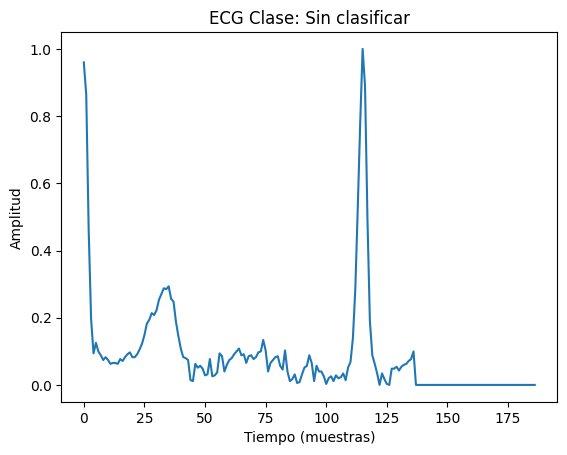

In [449]:
# Graficando un ECG
plot_ecg(X=X_train[1], y=y_train[1])

In [450]:
# Clusters con K-means
train_kmeans = KMeans(n_clusters=5, random_state=SEED)
train_clusters = train_kmeans.fit_predict(X_train)

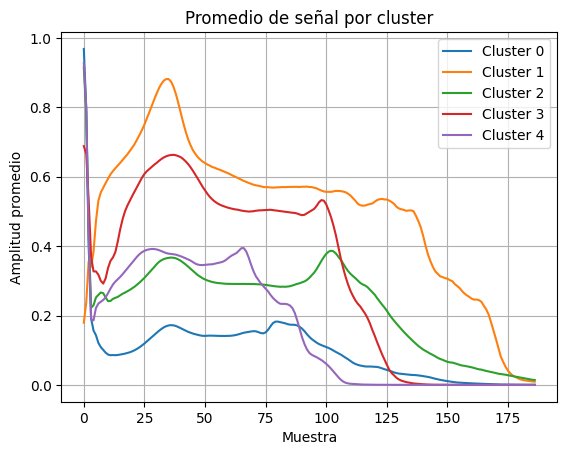

In [451]:
plot_clusters(X=X_train, clusters=train_clusters, n_clusters=5)

In [452]:
# Hacemos un conteo por clases
unique, counts = np.unique(y_train, return_counts=True)
for c, n in zip(unique, counts):
	if not np.isnan(c):
		c = int(c)
	print(f"Clase {c}: {n} muestras ({n/len(y_train)*100:.2f}%)")

Clase 0: 36236 muestras (41.39%)
Clase 1: 1112 muestras (1.27%)
Clase 2: 2894 muestras (3.31%)
Clase 3: 321 muestras (0.37%)
Clase 4: 3216 muestras (3.67%)
Clase nan: 43775 muestras (50.00%)


In [508]:
n_classes = 5

# ============================
# 1) Pesos para la FUNCIÓN DE PÉRDIDA
# ============================
y_valid = y_train[~np.isnan(y_train)]
y_valid = y_valid[y_valid >= 0].astype(int)

print("Clases en y_valid:", np.unique(y_valid))

class_counts = np.bincount(y_valid, minlength=n_classes)
print("Cantidad por clase (0..4):", class_counts)

# Pesos base: 1 / sqrt(freq)
inv_sqrt = 1.0 / np.sqrt(class_counts + 1e-8)
inv_sqrt = inv_sqrt / inv_sqrt.mean()
print("Pesos 1/sqrt(freq) normalizados:", inv_sqrt)

# Suavizado extra
alpha = 0.1
class_weights_np = inv_sqrt ** alpha
class_weights_np = class_weights_np / class_weights_np.mean()
print("Pesos por clase suavizados para LOSS (0..4):", class_weights_np)

# Tensor PARA LA LOSS (float32)
class_weights_loss = torch.tensor(class_weights_np, dtype=torch.float32)

Clases en y_valid: [0 1 2 3 4]
Cantidad por clase (0..4): [36236  1112  2894   321  3216]
Pesos 1/sqrt(freq) normalizados: [0.20636958 1.17804916 0.73024156 2.1926196  0.6927201 ]
Pesos por clase suavizados para LOSS (0..4): [0.87407997 1.04040623 0.9918209  1.10709001 0.98660288]


## **6. Modelo basado en TimeCLR**

### **6.1 Augmentaciones del Modelo**

In [454]:
class ECGTimeAugment:
	def __init__(
		self,
		series_len: int = 187,
		p_jitter: float = 0.7,		jitter_sigma: float = 0.008,   # ruido leve
		p_scaling: float = 0.6,		scaling_sigma: float = 0.05,  # ganancia leve
		p_tmask: float = 0.3,		tmask_frac=(0.02, 0.06),      # cutout corto
		p_crop: float = 0.5,		crop_frac=(0.8, 0.98),        # recorte moderado
		use_perm: bool = False
	):
		self.T = series_len
		self.p_jitter = p_jitter; self.jitter_sigma = jitter_sigma
		self.p_scaling = p_scaling; self.scaling_sigma = scaling_sigma
		self.p_tmask = p_tmask; self.tmask_frac = tmask_frac
		self.p_crop = p_crop; self.crop_frac = crop_frac
		self.use_perm = use_perm

	def _jitter(self, x):
		y = x + np.random.normal(0.0, self.jitter_sigma, size=x.shape)
		return y.astype(x.dtype, copy=False)

	def _scaling(self, x):
		y = x * np.random.normal(1.0, self.scaling_sigma)
		return y.astype(x.dtype, copy=False)

	def _time_mask(self, x):
		y = x.astype(np.float32, copy=False).copy()
		w = max(1, int(self.T * np.random.uniform(*self.tmask_frac)))
		s = np.random.randint(0, max(1, self.T - w + 1))
		y[s:s+w] = 0.0
		return y.astype(x.dtype, copy=False)

	def _crop(self, x):
		w = max(2, int(self.T * np.random.uniform(*self.crop_frac)))
		s = np.random.randint(0, max(1, self.T - w + 1))
		seg = x[s:s+w]
		i_old = np.linspace(0, 1, num=w)
		i_new = np.linspace(0, 1, num=self.T)
		y = np.interp(i_new, i_old, seg)   # -> float64
		return y.astype(x.dtype, copy=False)

	def __call__(self, x):
		y = x
		if np.random.rand() < self.p_crop:
			y = self._crop(y)
		if np.random.rand() < self.p_tmask:
			y = self._time_mask(y)
		if np.random.rand() < self.p_scaling:
			y = self._scaling(y)
		if np.random.rand() < self.p_jitter:
			y = self._jitter(y)
		return np.ascontiguousarray(y, dtype=np.float32)
	
ecgtime_augment = ECGTimeAugment(series_len=SIGNALS)

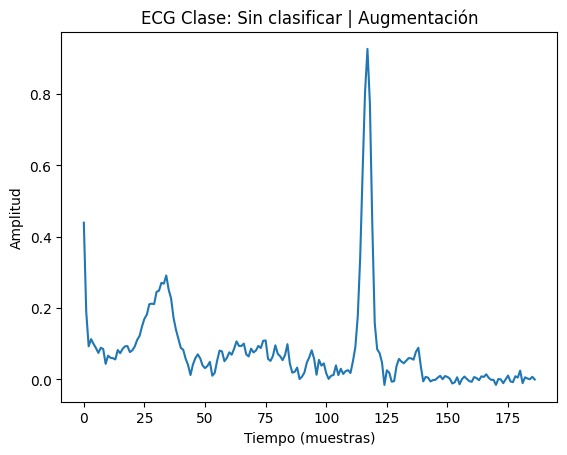

In [455]:
aug = ecgtime_augment(X_train[1])
plot_ecg(X=aug, y=y_train[1], aug=True, aug_title="Augmentación")

### **6.2 Dataset del Modelo**

In [456]:
class TimeCLRDataset(Dataset):
	def __init__(self, X, transform=None, eps=1e-6):
		X = np.asarray(X, dtype=np.float32)
		if X.ndim == 2:
			self.X = X
		elif X.ndim == 3 and X.shape[1] == 1:
			self.X = X[:, 0, :]
		else:
			raise ValueError("X debe ser (N, T) o (N, 1, T)")
		self.T = self.X.shape[1]
		self.transform = transform
		self.eps = eps

	def __len__(self): return self.X.shape[0]

	def _z(self, x):
		m, s = x.mean(), x.std()
		return (x - m) / (s + self.eps)

	def __getitem__(self, idx: int):
		x = self.X[idx]
		a1 = self.transform(x) if self.transform else x
		a2 = self.transform(x) if self.transform else x

		a1 = self._z(a1).astype(np.float32, copy=False)
		a2 = self._z(a2).astype(np.float32, copy=False)

		# importante: contiguo antes de from_numpy
		a1 = np.ascontiguousarray(a1)
		a2 = np.ascontiguousarray(a2)

		x1 = torch.from_numpy(a1).unsqueeze(0)
		x2 = torch.from_numpy(a2).unsqueeze(0)
		return x1, x2

class LabeledECGDataset(Dataset):
	def __init__(self, X, y, eps=1e-6, transform=None, p_aug=0.0):
		self.X = np.asarray(X, dtype=np.float32)
		self.y = np.asarray(y, dtype=np.int64)
		self.eps = eps
		self.transform = transform
		self.p_aug = p_aug

	def __len__(self):
		return self.X.shape[0]

	def _z(self, x):
		m, s = x.mean(), x.std()
		return (x - m) / (s + self.eps)

	def __getitem__(self, i):
		x = self.X[i]

		if self.transform is not None and np.random.rand() < self.p_aug:
			x = self.transform(x)

		x = self._z(x)
		x = np.ascontiguousarray(x, dtype=np.float32)
		x = torch.from_numpy(x).unsqueeze(0)
		y = torch.tensor(self.y[i])
		return x, y

class UnlabeledECGDataset(Dataset):
	def __init__(self, X, eps=1e-6):
		self.X = np.asarray(X, dtype=np.float32)
		self.eps = eps

	def __len__(self): return self.X.shape[0]

	def _z(self, x):
		m, s = x.mean(), x.std()
		return (x - m) / (s + self.eps)

	def __getitem__(self, i):
		x = self._z(self.X[i])
		x = np.ascontiguousarray(x, dtype=np.float32)
		x = torch.from_numpy(x).unsqueeze(0)
		return x

### **6.3 Backbone del Modelo**

##### **6.3.a Backbone 1**

In [457]:
class CNN1DBackbone(nn.Module):
	def __init__(self, in_ch: int = 1, emb_dim: int = 256):
		super().__init__()
		self.feat = nn.Sequential(
			nn.Conv1d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False),
			nn.BatchNorm1d(64),
			nn.ReLU(inplace=True),

			nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),
			nn.BatchNorm1d(128),
			nn.ReLU(inplace=True),

			nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
			nn.BatchNorm1d(256),
			nn.ReLU(inplace=True),

			nn.AdaptiveAvgPool1d(1)
		)
		self.fc = nn.Linear(256, emb_dim)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		h = self.feat(x).squeeze(-1)
		z = self.fc(h)
		return z

##### **6.3.b Backbone 2**

In [458]:
class InceptionBlock1D(nn.Module):
	def __init__(self, in_ch, out_ch, kernel_sizes=(9, 19, 39), bottleneck_ch=32):
		super().__init__()
		self.use_bottleneck = in_ch > bottleneck_ch
		bottleneck_out = bottleneck_ch if self.use_bottleneck else in_ch

		self.bottleneck = nn.Conv1d(in_ch, bottleneck_out, kernel_size=1, bias=False) if self.use_bottleneck else nn.Identity()
		self.branch1 = nn.Conv1d(bottleneck_out, out_ch, kernel_size=kernel_sizes[0], padding=kernel_sizes[0]//2, bias=False)
		self.branch2 = nn.Conv1d(bottleneck_out, out_ch, kernel_size=kernel_sizes[1], padding=kernel_sizes[1]//2, bias=False)
		self.branch3 = nn.Conv1d(bottleneck_out, out_ch, kernel_size=kernel_sizes[2], padding=kernel_sizes[2]//2, bias=False)
		self.branch_pool = nn.Sequential(
			nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
			nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
		)
		self.bn = nn.BatchNorm1d(4 * out_ch)
		self.relu = nn.ReLU(inplace=True)

	def forward(self, x):
		x_b = self.bottleneck(x)
		y1 = self.branch1(x_b)
		y2 = self.branch2(x_b)
		y3 = self.branch3(x_b)
		y4 = self.branch_pool(x)
		y = torch.cat([y1, y2, y3, y4], dim=1)
		return self.relu(self.bn(y))

class InceptionBlockResidual1D(nn.Module):
	def __init__(self, in_ch, out_ch, **kwargs):
		super().__init__()
		self.inc = InceptionBlock1D(in_ch, out_ch, **kwargs)
		self.res = nn.Sequential(
			nn.Conv1d(in_ch, 4*out_ch, kernel_size=1, bias=False),
			nn.BatchNorm1d(4*out_ch)
		) if in_ch != 4*out_ch else nn.Identity()
		self.relu = nn.ReLU(inplace=True)

	def forward(self, x):
		y = self.inc(x)
		res = x if isinstance(self.res, nn.Identity) else self.res(x)
		return self.relu(y + res)

class InceptionTimeBackbone(nn.Module):
	def __init__(self, in_ch=1, emb_dim=256, base_ch=32, n_blocks=6):
		super().__init__()
		ch = in_ch
		blocks = []
		for i in range(n_blocks):
			blocks.append(InceptionBlockResidual1D(
				in_ch=ch, out_ch=base_ch, kernel_sizes=(9,19,39), bottleneck_ch=32
			))
			ch = 4 * base_ch
			if (i + 1) % 2 == 0:
				blocks.append(nn.MaxPool1d(kernel_size=2, stride=2))  # downsample suave
		self.feat = nn.Sequential(*blocks, nn.AdaptiveAvgPool1d(1))
		self.fc = nn.Linear(ch, emb_dim)

	def forward(self, x):
		h = self.feat(x).squeeze(-1)
		return self.fc(h)

##### **6.3.c Backbone 3**

In [459]:
class ResBlock1D(nn.Module):
	def __init__(self, in_ch, out_ch, k=7, stride=1, dilation=1):
		super().__init__()
		p = (k//2) * dilation
		self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=k, stride=stride, padding=p, dilation=dilation, bias=False)
		self.bn1 = nn.BatchNorm1d(out_ch)
		self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=k, stride=1, padding=p, dilation=dilation, bias=False)
		self.bn2 = nn.BatchNorm1d(out_ch)
		self.shortcut = nn.Sequential(
			nn.Conv1d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
			nn.BatchNorm1d(out_ch)
		) if (in_ch != out_ch or stride != 1) else nn.Identity()
		self.relu = nn.ReLU(inplace=True)

	def forward(self, x):
		y = self.relu(self.bn1(self.conv1(x)))
		y = self.bn2(self.conv2(y))
		y = y + (x if isinstance(self.shortcut, nn.Identity) else self.shortcut(x))
		return self.relu(y)

class ResNet1DBackbone(nn.Module):
	def __init__(self, in_ch=1, emb_dim=256, widths=(64,128,256,256), dilations=(1,2,4,8)):
		super().__init__()
		layers = []
		ch = in_ch
		for w, d in zip(widths, dilations):
			layers += [
				ResBlock1D(ch, w, k=7, stride=2, dilation=d),
				ResBlock1D(w, w, k=7, stride=1, dilation=d)
			]
			ch = w
		self.feat = nn.Sequential(*layers, nn.AdaptiveAvgPool1d(1))
		self.fc = nn.Linear(ch, emb_dim)

	def forward(self, x):
		h = self.feat(x).squeeze(-1)
		return self.fc(h)

### **6.4 ProjectionHead del Modelo**

##### **6.4.a ProjectionHead 1**

In [460]:
class ProjectionHeadOne(nn.Module):
	def __init__(self, in_dim: int, hid_dim: int = 256, out_dim: int = 128):
		super().__init__()
		self.net = nn.Sequential(
			nn.Linear(in_dim, hid_dim, bias=False),
			nn.BatchNorm1d(hid_dim),
			nn.ReLU(inplace=True),
			nn.Linear(hid_dim, out_dim, bias=True)
		)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.net(x)

##### **6.4.a ProjectionHead 2**

In [461]:
class ProjectionHeadTwo(nn.Module):
	def __init__(self, in_dim, hid_dim=128, out_dim=128, p_drop=0.6):
		super().__init__()
		self.net = nn.Sequential(
			nn.LayerNorm(in_dim),
			nn.Linear(in_dim, hid_dim),
			nn.ReLU(inplace=True),
			nn.Dropout(p_drop),
			nn.Linear(hid_dim, n_classes),
		)
	def forward(self, x): return self.net(x)

### **6.5 Clasificador del Modelo**

##### **6.5.a Clasificador 1**

In [462]:
class ClassifierHeadOne(nn.Module):
	def __init__(self, in_dim=256, hid=256, n_classes=5, p_drop=0.4):
		super().__init__()
		self.net = nn.Sequential(
			nn.LayerNorm(in_dim),
			nn.Linear(in_dim, hid),
			nn.ReLU(inplace=True),
			nn.Dropout(p_drop),
			nn.Linear(hid, n_classes),
		)
	def forward(self, x): return self.net(x)

##### **6.5.b Clasificador 2**

In [463]:
class ClassifierHeadTwo(nn.Module):
	def __init__(self, in_dim=256, hid=512, n_classes=5, p_drop=0.4):
		super().__init__()
		self.net = nn.Sequential(
			nn.LayerNorm(in_dim),
			nn.Linear(in_dim, hid),
			nn.ReLU(inplace=True),
			nn.Dropout(p_drop),
			nn.Linear(hid, n_classes),
		)
	def forward(self, x): return self.net(x)

### **6.6 LossFunction del Modelo**

##### **6.6.a NTXentLoss**

In [464]:
def nt_xent_loss(z1: torch.Tensor, z2: torch.Tensor, temperature: float = 0.2) -> torch.Tensor:
	# Normaliza
	z1 = F.normalize(z1, dim=1)
	z2 = F.normalize(z2, dim=1)

	B = z1.size(0)

	Z = torch.cat([z1, z2], dim=0)

	if Z.dtype in (torch.float16, torch.bfloat16):
		Zm = Z.float()
	else:
		Zm = Z

	sim = torch.matmul(Zm, Zm.t()) / temperature

	mask = torch.eye(2 * B, dtype=torch.bool, device=Z.device)
	sim = sim.masked_fill(mask, float('-inf'))

	target = torch.cat([
		torch.arange(B, 2 * B, device=Z.device),
		torch.arange(0, B, device=Z.device)
	], dim=0)

	loss = F.cross_entropy(sim, target)
	return loss

##### **6.6.b FocalLoss**

In [465]:
class FocalLoss(torch.nn.Module):
	def __init__(self, gamma=2.0, weight=None):
		super().__init__()
		self.gamma = gamma
		self.weight = weight
	def forward(self, logits, target):
		logp = F.log_softmax(logits, dim=1)
		p = logp.exp()
		ce = F.nll_loss(logp, target, reduction="none", weight=self.weight)
		pt = p.gather(1, target.unsqueeze(1)).squeeze(1)
		return ((1 - pt) ** self.gamma * ce).mean()

### **6.7 Arquitectura del Modelo**

In [466]:
class TimeCLRModel(pl.LightningModule):
	def __init__(
		self,
		emb_dim: int = EMBEDDING_DIM,
		proj_hid: int = PROJ_HID,
		proj_out: int = PROJ_OUT,
		temperature: float = TEMP,
		lr: float = LR_SSL,
		weight_decay: float = WD
	):
		super().__init__()
		self.save_hyperparameters()

		if ENCODER == "CNN1DBackbone":
			self.encoder = CNN1DBackbone(in_ch=1, emb_dim=emb_dim)
		elif ENCODER == "InceptionTimeBackbone":
			self.encoder = InceptionTimeBackbone(in_ch=1, emb_dim=emb_dim) 
		elif ENCODER == "ResNet1DBackbone":
			self.encoder = ResNet1DBackbone(in_ch=1, emb_dim=emb_dim) 
		else:
			raise ValueError
		
		if PROJECTOR == "ProjectionHeadOne":
			self.projector = ProjectionHeadOne(emb_dim, proj_hid, proj_out)
		elif PROJECTOR == "ProjectionHeadTwo":
			self.projector = ProjectionHeadTwo(emb_dim, proj_hid, proj_out)
		else:
			raise ValueError
		
		self.temperature = temperature
		self.lr = lr
		self.weight_decay = weight_decay

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		h = self.encoder(x)
		z = self.projector(h)
		return z

	def training_step(self, batch, batch_idx):
		x1, x2 = batch
		z1 = self(x1)
		z2 = self(x2)
		loss = nt_xent_loss(z1, z2, self.temperature)
		self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
		return loss

	def configure_optimizers(self):
		opt = AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

		steps_per_epoch = len(self.trainer.datamodule.train_dataloader()) if self.trainer.datamodule else len(self.trainer.fit_loop._data_source.dataloader())
		total_steps = self.trainer.max_epochs * steps_per_epoch
		warmup_steps = int(0.1 * total_steps)

		def warmup_then_cosine(step):
			if step < warmup_steps:
				return step / max(1, warmup_steps)
			progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
			return 0.5 * (1 + math.cos(math.pi * progress))

		if SCHEDULER == "LambdaLR":
			scheduler = LambdaLR(opt, lr_lambda=warmup_then_cosine)
		elif SCHEDULER == "CosineAnnealingLR":
			scheduler = CosineAnnealingLR(opt, T_max=self.trainer.max_epochs)
		else:
			raise ValueError

		return {"optimizer": opt, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

	@torch.no_grad()
	def encode(self, x: torch.Tensor, normalize: bool = True) -> torch.Tensor:
		h = self.encoder(x)
		if normalize:
			h = F.normalize(h, dim=1)
		return h

### **6.7 Pre-Entrenamiento del Modelo**

In [ ]:
X_all_train = X_train
ssl_ds = TimeCLRDataset(
	X=X_all_train,
	transform=ecgtime_augment
)
ssl_dl = DataLoader(
	ssl_ds,
	batch_size=BATCH_SSL,
	shuffle=True,
	num_workers=NUM_WORKERS
)

timeclr_model = TimeCLRModel(
	emb_dim=EMBEDDING_DIM,
	proj_hid=PROJ_HID,
	proj_out=PROJ_OUT,
	temperature=TEMP,
	lr=LR_SSL,
	weight_decay=WD
)

steps_per_epoch = max(1, len(ssl_dl))
warmup_steps = int(0.1 * EPOCHS_SSL * steps_per_epoch)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
	max_epochs=EPOCHS_SSL,
	accelerator="gpu" if torch.cuda.is_available() else "cpu",
	devices=1,
	precision="16-mixed" if torch.cuda.is_available() else 32,
	benchmark=True,
	log_every_n_steps=10,
	gradient_clip_val=1.0,
	callbacks=[lr_monitor]
)
trainer.fit(timeclr_model, ssl_dl)

encoder = timeclr_model.encoder.eval()

In [ ]:
encoder_path = f"checkpoints/encoder_{ENCODER}_ssl_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pt"
torch.save(encoder.state_dict(), encoder_path)
print(f"Encoder SSL guardado en: {encoder_path}")

### **6.8 LinearProbe**

In [ ]:
class LinearProbe(pl.LightningModule):
	def __init__(
		self,
		encoder,
		n_classes: int,
		lr: float = LR_LP,
		wd: float = WD,
		class_weights: torch.Tensor | None = None
	):
		super().__init__()
		self.encoder = encoder
		self.lr, self.wd = lr, wd
		self.n_classes = n_classes

		for p in self.encoder.parameters():
			p.requires_grad = False
		
		if HEAD == "ClassifierHeadOne":
			self.head = ClassifierHeadOne(in_dim=EMBEDDING_DIM, hid=256, n_classes=n_classes, p_drop=0.4)
		elif HEAD == "ClassifierHeadTwo":
			self.head = ClassifierHeadTwo(in_dim=EMBEDDING_DIM, hid=128, n_classes=n_classes, p_drop=0.6)
		elif HEAD == "Linear":
			self.head = nn.Linear(256, n_classes)
		else:
			raise ValueError(f"Cabeza desconocida: {HEAD}")
		
		# Guardamos los pesos como buffer (se mueven con el modelo a cuda/cpu)
		if class_weights is not None:
			self.register_buffer("class_weights", class_weights.clone().float())
		else:
			self.class_weights = None
		
		if LOSS_LP == "FocalLoss":
			self.criterion = self._focal_loss_lp
		elif LOSS_LP == "CrossEntropy":
			self.criterion = self._ce_loss_lp
		else:
			raise ValueError(f"Función de pérdida desconocida: {LOSS_LP}")

	def _get_weights(self, logits):
		if self.class_weights is None:
			return None
		return self.class_weights.to(device=logits.device, dtype=logits.dtype)

	def _focal_loss_lp(self, logits, y):
		w = self._get_weights(logits)
		return FocalLoss(
			gamma=GAMMA_LP,
			weight=w
		)(logits, y)

	def _ce_loss_lp(self, logits, y):
		w = self._get_weights(logits)
		return F.cross_entropy(
			logits,
			y,
			#weight=w,
			label_smoothing=0.05
		)

	def forward(self, x):
		with torch.no_grad():
			h = self.encoder(x)
		logits = self.head(h)
		return logits

	def _compute_batch_metrics(self, logits, y, split: str):
		"""
		split: 'lp_train' o 'lp_val' para prefijar bien los nombres de logs.
		"""
		pred = logits.argmax(dim=1)

		acc = (pred == y).float().mean()

		f1_per_class = []
		for c in range(self.n_classes):
			tp = ((pred == c) & (y == c)).sum().float()
			fp = ((pred == c) & (y != c)).sum().float()
			fn = ((pred != c) & (y == c)).sum().float()

			precision = tp / (tp + fp + 1e-8)
			recall = tp / (tp + fn + 1e-8)
			f1 = 2 * precision * recall / (precision + recall + 1e-8)
			f1_per_class.append(f1)

			self.log(
				f"{split}_f1_class_{c}",
				f1,
				on_step=False,
				on_epoch=True,
				prog_bar=False,
				logger=True,
			)

		f1_macro = torch.stack(f1_per_class).mean()
		return acc, f1_macro

	def training_step(self, batch, _):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)

		acc, f1_macro = self._compute_batch_metrics(logits, y, split="lp_train")

		self.log("lp_train_loss", loss, prog_bar=True, on_step=True, on_epoch=True, logger=True)
		self.log("lp_train_acc", acc, prog_bar=True, on_step=False, on_epoch=True, logger=True)
		self.log("lp_train_f1_macro", f1_macro, prog_bar=True, on_step=False, on_epoch=True, logger=True)

		return loss
	
	def validation_step(self, batch, _):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)

		acc, f1_macro = self._compute_batch_metrics(logits, y, split="lp_val")

		self.log("lp_val_loss", loss, prog_bar=True, on_step=True, on_epoch=True, logger=True)
		self.log("lp_val_acc", acc, prog_bar=True, on_step=False, on_epoch=True, logger=True)
		self.log("lp_val_f1_macro", f1_macro, prog_bar=True, on_step=False, on_epoch=True, logger=True)

		return loss

	def test_step(self, batch, _):
		x, y = batch
		logits = self(x)
		pred = logits.argmax(1)
		acc = (pred == y).float().mean()
		self.log("lp_test_acc", acc, prog_bar=True)

	def configure_optimizers(self):
		return AdamW(self.head.parameters(), lr=self.lr, weight_decay=self.wd)

In [510]:
# recreas el mismo backbone que usaste en TimeCLRModel
if ENCODER == "CNN1DBackbone":
	encoder = CNN1DBackbone(in_ch=1, emb_dim=EMBEDDING_DIM)
elif ENCODER == "InceptionTimeBackbone":
	encoder = InceptionTimeBackbone(in_ch=1, emb_dim=EMBEDDING_DIM)
elif ENCODER == "ResNet1DBackbone":
	encoder = ResNet1DBackbone(in_ch=1, emb_dim=EMBEDDING_DIM)
else:
	raise ValueError

encoder_path = "checkpoints/encoder_ResNet1DBackbone_ssl_2025-11-11_12-00-45.pt"
encoder.load_state_dict(torch.load(encoder_path, map_location="cpu"))
encoder.eval()

C:\Users\cinto\AppData\Local\Temp\ipykernel_20488\2428609504.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_path, map_locati

ResNet1DBackbone(
  (feat): Sequential(
    (0): ResBlock1D(
      (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv1d(1, 64, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1

In [ ]:
# Split del set etiquetado en train / val
X_tr, X_val, y_tr, y_val = train_test_split(
	X_lab_train,
	y_lab_train.astype(int),
	test_size=0.25,
	stratify=y_lab_train,
	random_state=SEED
)

# Datasets
train_ds = LabeledECGDataset(X_tr, y_tr, transform=ecgtime_augment, p_aug=0.7)
val_ds = LabeledECGDataset(X_val, y_val)
test_ds = LabeledECGDataset(X_test, y_test.astype(int))

# ============================
# 2) Pesos para el SAMPLER de train
# ============================
y_tr_np = y_tr.astype(int)
class_counts_tr = np.bincount(y_tr_np, minlength=n_classes)
print("Cantidad por clase en y_tr (0..4):", class_counts_tr)

alpha = 0.15
inv_sampler = 1.0 / (class_counts ** alpha)
class_weights_sampler = inv_sampler / inv_sampler.mean()
print("Pesos por clase para SAMPLER (0..4):", class_weights_sampler)

sample_weights_np = class_weights_sampler[y_tr_np]
sample_weights = torch.from_numpy(sample_weights_np).float()
print("sample_weights shape:", sample_weights.shape)

# WeightedRandomSampler solo para train
sampler = WeightedRandomSampler(
	weights=sample_weights,
	num_samples=len(sample_weights),
	replacement=True
)

# DataLoader de entrenamiento para el LinearProbe
train_dl = DataLoader(
	train_ds,
	batch_size=BATCH_LP,
	sampler=sampler,
	shuffle=False,
	num_workers=NUM_WORKERS
)

# DataLoader de validación (sin sampler, sin shuffle)
val_dl = DataLoader(
	val_ds,
	batch_size=BATCH_LP,
	shuffle=False,
	num_workers=NUM_WORKERS
)

# DataLoader de testeo
test_dl = DataLoader(
	test_ds,
	batch_size=BATCH_LP,
	shuffle=False,
	num_workers=NUM_WORKERS
)

Cantidad por clase en y_tr (0..4): [27177   834  2170   241  2412]
Pesos por clase para SAMPLER (0..4): [0.20641307 1.17829741 0.73047958 2.19194386 0.69286607]
sample_weights shape: torch.Size([32834])


In [512]:
early_stop = EarlyStopping(
	monitor="lp_val_f1_macro",
	mode="max",
	patience=8,
	min_delta=1e-4
)

checkpoint = ModelCheckpoint(
	monitor="lp_val_f1_macro",
	mode="max",
	save_top_k=1,
	filename="lp-best-{epoch}-{lp_val_f1_macro:.4f}"
)

In [513]:
lp = LinearProbe(
	encoder=encoder,
	n_classes=n_classes,
	lr=LR_LP,
	wd=WD,
	class_weights=class_weights_loss
)
trainer = pl.Trainer(
	max_epochs=EPOCHS_LP,
	accelerator="gpu" if torch.cuda.is_available() else "cpu",
	devices=1,
	callbacks=[early_stop, checkpoint]
)

# Entrenamiento con datos etiquetados
trainer.fit(lp, train_dl, val_dl)

# Cargar el mejor modelo según val_f1_macro
best_lp = LinearProbe.load_from_checkpoint(
	checkpoint.best_model_path,
	encoder=encoder,
	n_classes=num_classes,
	lr=LR_LP,
	wd=WD,
	class_weights=class_weights_loss
)

# Testeo con el mejor checkpoint
trainer.test(best_lp, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | encoder | ResNet1DBackbone  | 4.1 M  | eval 
1 | head    | ClassifierHeadOne | 67.6 K | train
------------------------------------------------------
67.6 K    Trainable params
4.1 M     Non-trainable params
4.2 M     Total params
16.702    Total estimated model params size (MB)
7         Modules in train mode
68        Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 16: 100%|██████████| 129/129 [00:08<00:00, 14.41it/s, v_num=107, lp_train_loss_step=0.365, lp_val_loss_step=0.356, lp_val_loss_epoch=0.368, lp_val_acc=0.958, lp_val_f1_macro=0.810, lp_train_loss_epoch=0.367, lp_train_acc=0.958, lp_train_f1_macro=0.940]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 86/86 [00:01<00:00, 49.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        lp_test_acc        │     0.961856484413147     │
└───────────────────────────┴───────────────────────────┘

[{'lp_test_acc': 0.961856484413147}]

In [514]:
linearprobe_path = f"checkpoints/linearprobe_{HEAD}_head_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pt"
torch.save(lp.head.state_dict(), linearprobe_path)
print(f"Cabeza del LinearProbe guardada en: {linearprobe_path}")

Cabeza del LinearProbe guardada en: checkpoints/linearprobe_ClassifierHeadOne_head_2025-11-11_18-53-54.pt


### **6.9 FineTuning TimeCLR**

In [ ]:
class FineTune(pl.LightningModule):
	def __init__(
		self,
		encoder,
		n_classes: int,
		lr_enc=LR_FT_ENC,
		lr_head=LR_FT_HEAD,
		wd=WD,
		class_weights: torch.Tensor | None = None
	):
		super().__init__()
		self.encoder = encoder
		self.lr_enc, self.lr_head, self.wd = lr_enc, lr_head, wd
		self.n_classes = n_classes

		for p in self.encoder.parameters():
			p.requires_grad = False
		if hasattr(self.encoder, "fc"):
			for p in self.encoder.fc.parameters():
				p.requires_grad = True

		if HEAD == "ClassifierHeadOne":
			self.head = ClassifierHeadOne(in_dim=EMBEDDING_DIM, hid=256, n_classes=n_classes, p_drop=0.4)
		elif HEAD == "ClassifierHeadTwo":
			self.head = ClassifierHeadTwo(in_dim=EMBEDDING_DIM, hid=128, n_classes=n_classes, p_drop=0.6)
		elif HEAD == "Linear":
			self.head = nn.Linear(256, n_classes)
		else:
			raise ValueError(f"Cabeza desconocida: {HEAD}")

		if class_weights is not None:
			self.register_buffer("class_weights", class_weights.clone().float())
		else:
			self.class_weights = None
		
		if LOSS_FN == "FocalLoss":
			self.criterion = self._focal_loss_ft
		elif LOSS_FN == "CrossEntropy":
			self.criterion = self._ce_loss_ft
		else:
			raise ValueError(f"Función de pérdida desconocida: {LOSS_FN}")

	def _get_weights(self, logits):
		if self.class_weights is None:
			return None
		return self.class_weights.to(device=logits.device, dtype=logits.dtype)

	def _focal_loss_ft(self, logits, y):
		w = self._get_weights(logits)
		return FocalLoss(
			gamma=GAMMA_FN,
			weight=w
		)(logits, y)

	def _ce_loss_ft(self, logits, y):
		w = self._get_weights(logits)
		return F.cross_entropy(
			logits,
			y,
			#weight=w,
			label_smoothing=0.05
		)

	def forward(self, x):
		h = self.encoder(x)
		logits = self.head(h)
		return logits

	def _compute_batch_metrics(self, logits, y, split: str):
		"""
		split: 'ft_train', 'ft_val' o 'ft_test' para prefijar bien los nombres de logs.
		"""
		pred = logits.argmax(dim=1)

		acc = (pred == y).float().mean()

		f1_per_class = []
		for c in range(self.n_classes):
			tp = ((pred == c) & (y == c)).sum().float()
			fp = ((pred == c) & (y != c)).sum().float()
			fn = ((pred != c) & (y == c)).sum().float()

			precision = tp / (tp + fp + 1e-8)
			recall = tp / (tp + fn + 1e-8)
			f1 = 2 * precision * recall / (precision + recall + 1e-8)
			f1_per_class.append(f1)

			self.log(
				f"{split}_f1_class_{c}",
				f1,
				on_step=False,
				on_epoch=True,
				prog_bar=False,
				logger=True,
			)

		f1_macro = torch.stack(f1_per_class).mean()
		return acc, f1_macro
	
	def training_step(self, batch, _):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)

		acc, f1_macro = self._compute_batch_metrics(logits, y, split="ft_train")

		self.log("ft_train_loss", loss, prog_bar=True, on_step=True, on_epoch=True, logger=True)
		self.log("ft_train_acc", acc, prog_bar=True, on_step=False, on_epoch=True, logger=True)
		self.log("ft_train_f1_macro", f1_macro, prog_bar=True, on_step=False, on_epoch=True, logger=True)

		return loss

	def validation_step(self, batch, _):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)

		acc, f1_macro = self._compute_batch_metrics(logits, y, split="ft_val")

		self.log("ft_val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
		self.log("ft_val_acc", acc, prog_bar=True, on_step=False, on_epoch=True, logger=True)
		self.log("ft_val_f1_macro", f1_macro, prog_bar=True, on_step=False, on_epoch=True, logger=True)
		
		return loss

	def test_step(self, batch, _):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)

		acc, f1_macro = self._compute_batch_metrics(logits, y, split="ft_test")

		self.log("ft_test_loss", loss, prog_bar=False, on_step=False, on_epoch=True)
		self.log("ft_test_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
		self.log("ft_test_f1_macro", f1_macro, prog_bar=True, on_step=False, on_epoch=True)

		return loss

	def configure_optimizers(self):
		enc_params = [p for p in self.encoder.parameters() if p.requires_grad]
		head_params = [p for p in self.head.parameters() if p.requires_grad]

		param_groups = []
		if len(enc_params) > 0:
			param_groups.append({
				"params": enc_params,
				"lr": self.lr_enc,
				"weight_decay": self.wd,
			})
		if len(head_params) > 0:
			param_groups.append({
				"params": head_params,
				"lr": self.lr_head,
				"weight_decay": self.wd,
			})
		
		opt = AdamW(param_groups)
		sch = CosineAnnealingLR(opt, T_max=EPOCHS_FT)
		return {"optimizer": opt, "lr_scheduler": sch}

In [516]:
X_tr, X_val, y_tr, y_val = train_test_split(X_lab_train, y_lab_train, test_size=0.25, stratify=y_lab_train, random_state=SEED)

# Creamos nuestro WeightedRandomSampler para utilizar en nuestros DataLoaders
sampler = WeightedRandomSampler(
	weights=sample_weights,
	num_samples=len(sample_weights),
	replacement=True
)

# DataLoader de entrenamiento para el FineTuning
dl_tr = DataLoader(
	LabeledECGDataset(X_tr, y_tr, transform=ecgtime_augment, p_aug=0.7),
	batch_size=BATCH_FT,
	sampler=sampler,
	shuffle=False,
	num_workers=NUM_WORKERS
)

# DataLoader de validacion para el FineTuning
dl_val = DataLoader(
	LabeledECGDataset(X_val, y_val),
	batch_size=BATCH_FT,
	shuffle=False,
	num_workers=NUM_WORKERS
)

# DataLoader de testeo para el FineTuning
dl_te = DataLoader(
	test_ds,
	batch_size=BATCH_FT,
	shuffle=False,
	num_workers=NUM_WORKERS
)

In [517]:
early_stop = pl.callbacks.EarlyStopping(
	monitor="ft_val_f1_macro",
	mode="max",
	patience=6
)

ckpt = pl.callbacks.ModelCheckpoint(
	monitor="ft_val_f1_macro",
	mode="max",
	save_top_k=1
)

In [518]:
ft = FineTune(
	encoder=encoder,
	n_classes=n_classes,
	lr_enc=LR_FT_ENC,
	lr_head=LR_FT_HEAD,
	wd=WD,
	class_weights=class_weights_loss
)
trainer = pl.Trainer(
	max_epochs=EPOCHS_FT,
	accelerator="gpu" if torch.cuda.is_available() else "cpu",
	devices=1,
	callbacks=[early_stop, ckpt]
)

linearprobe_path = "checkpoints/linearprobe_ClassifierHeadOne_head_2025-11-11_18-53-54.pt"
ft.head.load_state_dict(torch.load(linearprobe_path, map_location="cpu"))
print("FineTune.head inicializada desde LinearProbe")

# Entrenamiento
trainer.fit(ft, dl_tr, dl_val)

# Testeo
trainer.test(ft, dl_te)	

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


C:\Users\cinto\AppData\Local\Temp\ipykernel_20488\459782293.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft.head.load_state_dict(torch.load(linearprobe_path, map_loc

FineTune.head inicializada desde LinearProbe
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 10: 100%|██████████| 129/129 [00:08<00:00, 14.38it/s, v_num=108, ft_train_loss_step=0.296, ft_val_loss=0.358, ft_val_acc=0.962, ft_val_f1_macro=0.817, ft_train_loss_epoch=0.344, ft_train_acc=0.969, ft_train_f1_macro=0.956]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 86/86 [00:03<00:00, 26.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        ft_test_acc        │    0.9656022787094116     │
│    ft_test_f1_class_0     │    0.8215311765670776     │
│    ft_test_f1_class_1     │   0.030460242182016373    │
│    ft_test_f1_class_2     │    0.07528673112392426    │
│    ft_test_f1_class_3     │   0.019492626190185547    │
│    ft_test_f1_class_4     │    0.07451572269201279    │
│     ft_test_f1_macro      │    0.20425724983215332    │
│       ft_test_loss        │    0.3516256511211395     │
└───────────────────────────┴───────────────────────────┘

[{'ft_test_f1_class_0': 0.8215311765670776,
  'ft_test_f1_class_1': 0.030460242182016373,
  'ft_test_f1_class_2': 0.07528673112392426,
  'ft_test_f1_class_3': 0.019492626190185547,
  'ft_test_f1_class_4': 0.07451572269201279,
  'ft_test_loss': 0.3516256511211395,
  'ft_test_acc': 0.9656022787094116,
  'ft_test_f1_macro': 0.20425724983215332}]

In [519]:
finetune_path = f"checkpoints/finetune_best_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.ckpt"
trainer.save_checkpoint(finetune_path)
print(f"Modelo FineTune guardado en: {finetune_path}")

Modelo FineTune guardado en: checkpoints/finetune_best_2025-11-11_18-55-56.ckpt


### **6.10 Evaluación del Modelo**

In [520]:
@torch.no_grad()
def evaluate_all_metrics(
	model: torch.nn.Module,
	dataloader,
	num_classes: int,
	class_names: Optional[List[str]] = None,
	device: Optional[torch.device] = None,
	normalize_cm: bool = True
) -> Dict[str, object]:
	model.eval()
	if device is None:
		device = next(model.parameters()).device

	all_preds = []
	all_probs = []
	all_true  = []

	for batch in dataloader:
		if isinstance(batch, (list, tuple)) and len(batch) == 2:
			x, y = batch
		else:
			raise ValueError("Dataloader debe entregar (x, y).")

		x = x.to(device)
		y = y.to(device)

		logits = model(x)
		probs  = F.softmax(logits, dim=1)
		preds  = probs.argmax(1)

		all_true.append(y.cpu().numpy())
		all_preds.append(preds.cpu().numpy())
		all_probs.append(probs.cpu().numpy())

	y_true = np.concatenate(all_true, axis=0)
	y_pred = np.concatenate(all_preds, axis=0)
	y_prob = np.concatenate(all_probs, axis=0)

	acc     = accuracy_score(y_true, y_pred)
	f1_mac  = f1_score(y_true, y_pred, average="macro", zero_division=0)
	rec_per_class = recall_score(y_true, y_pred, average=None, labels=np.arange(num_classes), zero_division=0)

	target_names = class_names if (class_names is not None and len(class_names) == num_classes) else None
	cls_report = classification_report(
		y_true, y_pred,
		target_names=target_names,
		zero_division=0,
		digits=4
	)

	cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
	if normalize_cm:
		with np.errstate(all="ignore"):
			cm_norm = cm / cm.sum(axis=1, keepdims=True)
			cm_norm = np.nan_to_num(cm_norm)
	else:
		cm_norm = None

	roc_auc_macro = None
	try:
		unique_test_classes = np.unique(y_true)
		if num_classes == 2:
			if set(unique_test_classes.tolist()) == {0, 1}:
				roc_auc_macro = roc_auc_score(y_true, y_prob[:, 1])
			else:
				classes_sorted = np.sort(unique_test_classes)
				mapper = {c:i for i, c in enumerate(classes_sorted)}
				y_true_bin = np.vectorize(mapper.get)(y_true)
				pos_index = np.where(classes_sorted == classes_sorted.max())[0][0]
				roc_auc_macro = roc_auc_score(y_true_bin, y_prob[:, pos_index])
		else:
			if len(unique_test_classes) >= 2:
				roc_auc_macro = roc_auc_score(y_true, y_prob, average="macro", multi_class="ovr")
			else:
				roc_auc_macro = None
	except Exception as e:
		roc_auc_macro = None

	results = {
		"f1_macro": f1_mac,
		"accuracy": acc,
		"recall_per_class": rec_per_class,
		"confusion_matrix": cm,
		"confusion_matrix_normalized": cm_norm,
		"roc_auc_macro": roc_auc_macro,
		"classification_report": cls_report,
	}

	# Impresión amigable
	print("\n=== Evaluación ===")
	print(f"F1-macro: {f1_mac:.4f}")
	print(f"Accuracy: {acc:.4f}")
	if roc_auc_macro is not None:
		print(f"ROC-AUC macro (OVR): {roc_auc_macro:.4f}")
	else:
		print("ROC-AUC macro: no disponible (clases ausentes o caso no válido).")

	print("\nRecall por clase:")
	if target_names is not None:
		for i, r in enumerate(rec_per_class):
			print(f"  {target_names[i]}: {r:.4f}")
	else:
		for i, r in enumerate(rec_per_class):
			print(f"  clase {i}: {r:.4f}")

	print("\nReporte por clase:\n", cls_report)
	print("Matriz de confusión (cruda):\n", cm)
	if cm_norm is not None:
		print("Matriz de confusión (normalizada por fila):\n", np.round(cm_norm, 4))

	return results

In [521]:
num_classes = int(np.unique(y_train[~np.isnan(y_train).astype(bool)]).size) if hasattr(y_train, "dtype") else int(np.unique(y_train).size)

class_names = [
	"(N) Latido normal",
	"(S) Latido supraventricular",
	"(V) Latido ventricular ectópico",
	"(F) Latido de fusión",
	"(Q) Latido desconocido"
]

results = evaluate_all_metrics(
	model=ft,
	dataloader=test_dl,
	num_classes=num_classes,
	class_names=class_names
)


=== Evaluación ===
F1-macro: 0.8380
Accuracy: 0.9656
ROC-AUC macro (OVR): 0.9826

Recall por clase:
  (N) Latido normal: 0.9798
  (S) Latido supraventricular: 0.7626
  (V) Latido ventricular ectópico: 0.9006
  (F) Latido de fusión: 0.7284
  (Q) Latido desconocido: 0.9583

Reporte por clase:
                                  precision    recall  f1-score   support

              (N) Latido normal     0.9847    0.9798    0.9822     18117
    (S) Latido supraventricular     0.7531    0.7626    0.7578       556
(V) Latido ventricular ectópico     0.8752    0.9006    0.8877      1448
           (F) Latido de fusión     0.5021    0.7284    0.5945       162
         (Q) Latido desconocido     0.9778    0.9583    0.9680      1608

                       accuracy                         0.9656     21891
                      macro avg     0.8186    0.8659    0.8380     21891
                   weighted avg     0.9675    0.9656    0.9664     21891

Matriz de confusión (cruda):
 [[17751   131   

### **6.11 Logit Adjustment**

### **6.12 Escritura en CSV**

In [ ]:
@torch.no_grad()
def write_predictions_csv(model, test_dl, out_path="preds.csv"):
	model.eval()
	device = next(model.parameters()).device

	ids = []
	preds = []
	running_id = 0

	for batch in test_dl:
		if isinstance(batch, (list, tuple)) and len(batch) >= 1:
			x = batch[0]
		else:
			x = batch

		bsz = x.size(0)
		x = x.to(device)

		logits = model(x)
		p = F.softmax(logits, dim=1)
		yhat = p.argmax(1).cpu().numpy()

		ids.extend(range(running_id, running_id + bsz))
		preds.extend(yhat.tolist())
		running_id += bsz

	df = pd.DataFrame({"ID": ids, "label": preds})
	df.to_csv(out_path, index=False)
	print(f"CSV de predicciones guardado en: {out_path}")

write_predictions_csv(
	ft,
	test_dl,
	out_path=f"ecg_submittions/timeclr_predictions_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
)